# 24. Variational AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 24.1 Preparing MNIST Data

In [3]:
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=1,
                                         shuffle=True)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

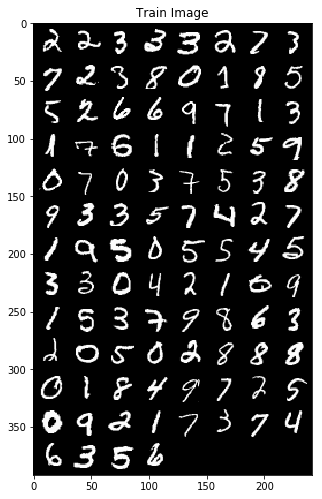

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

## 24.2 Define Model

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,5),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2) #64*3*3
        )
        
        self.f_mu = nn.Sequential(
            nn.Linear(64*3*3, 200),
            nn.Linear(200, 50)
        )
        
        self.f_std_log = nn.Sequential(
            nn.Linear(64*3*3, 200),
            nn.Linear(200, 50)
        )
        
        self.relu = nn.ReLU()
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
#                 Weight Initialization
#                 init.xavier_normal(m.weight.data)
                nn.init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
        
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)                
        
    def encode(self, x) :
        out = self.encoder(x)
        out = out.view(-1, 64*3*3)
        out = self.relu(out)
        
        mu = self.f_mu(out)
        std_log = self.f_std_log(out)
        
        return mu, std_log
        
    def f_latent(self, mu, std_log) :
        if self.training :

            std = std_log.exp()

            random = torch.randn(std.shape)
            random = Variable(random).cuda()

            z = random * std + mu

            return z

        else :
            
            return mu
        
    def forward(self, x):
        mu, std_log = self.encode(x)
        z = self.f_latent(mu, std_log)
        
        return mu, std_log, z

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(50, 200),
            nn.Linear(200, 64*3*3)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,5,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,1,4,stride=2,padding=1),
            nn.ReLU()
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        out = self.fc(z)
        out = out.view(-1,64,3,3)
        out = self.decoder(out)
        out = self.sigmoid(out)
        out = out.view(-1,1,28,28)
        
        return out

In [9]:
E = Encoder().cuda()
D = Decoder().cuda()

## 22.3 Model Training

In [10]:
reconstruction_loss = nn.BCELoss(size_average=False)

def KLD_loss(mu, std_log) :
    var_log = 2*std_log
    return torch.sum(var_log.exp() + mu.pow(2) - 1 - var_log)/2

optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [11]:
num_epochs = 5

In [12]:
for epoch in range(num_epochs):
    
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = Variable(batch_images).cuda()
        
        mu, std_log, z = E(X)
        pre = D(z)
        
        cost = reconstruction_loss(pre, X) + KLD_loss(mu, std_log)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.data[0]))
    
print("Learning Finished!")

Epoch [1/5], lter [100/600] Loss: 62599.4727
Epoch [1/5], lter [200/600] Loss: 60701.6328
Epoch [1/5], lter [300/600] Loss: 58973.0000
Epoch [1/5], lter [400/600] Loss: 58047.5078
Epoch [1/5], lter [500/600] Loss: 57016.4258
Epoch [1/5], lter [600/600] Loss: 55566.7891
Epoch [2/5], lter [100/600] Loss: 54814.3828
Epoch [2/5], lter [200/600] Loss: 54530.4570
Epoch [2/5], lter [300/600] Loss: 54324.7266
Epoch [2/5], lter [400/600] Loss: 54117.6484
Epoch [2/5], lter [500/600] Loss: 54101.5039
Epoch [2/5], lter [600/600] Loss: 53933.3438
Epoch [3/5], lter [100/600] Loss: 53784.5312
Epoch [3/5], lter [200/600] Loss: 54007.1797
Epoch [3/5], lter [300/600] Loss: 53857.3555
Epoch [3/5], lter [400/600] Loss: 53747.9414
Epoch [3/5], lter [500/600] Loss: 53668.9805
Epoch [3/5], lter [600/600] Loss: 54123.3203
Epoch [4/5], lter [100/600] Loss: 53878.3438
Epoch [4/5], lter [200/600] Loss: 53713.8164
Epoch [4/5], lter [300/600] Loss: 53663.7383
Epoch [4/5], lter [400/600] Loss: 53647.5547
Epoch [4/5

## 22.4 Test Model

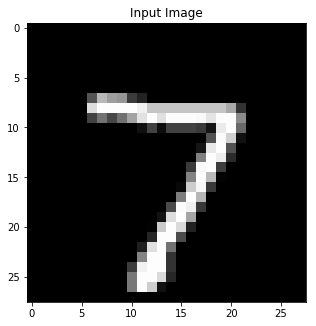

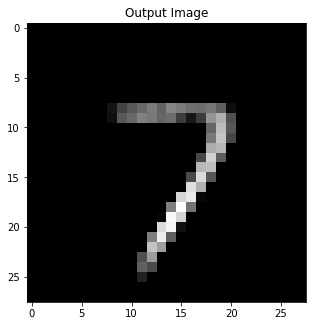

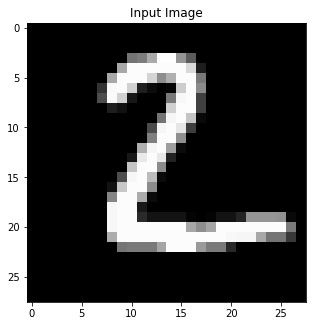

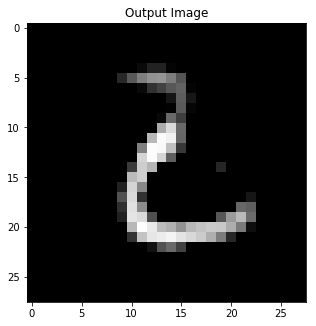

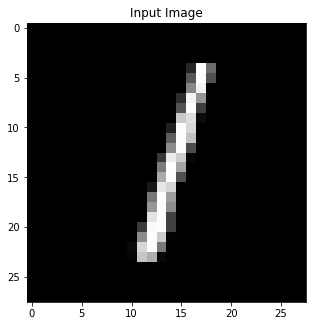

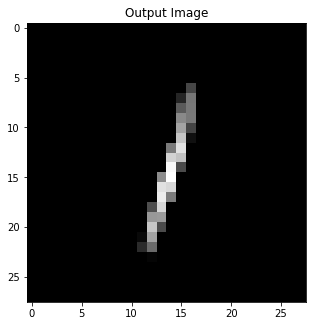

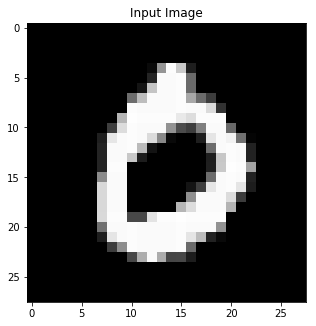

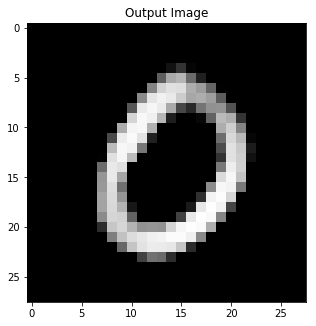

In [13]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(mnist_test):
    
    imshow(torchvision.utils.make_grid(images, normalize=True), "Input Image")
    images = Variable(images.view(-1, 1, 28, 28)).cuda()
    
    mu, std_log, z = E(images)
    outputs = D(z)
    outputs = outputs.view(-1, 1, 28, 28)
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break